# Custom GTZAN Dataset

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


class GTZANDataset(Dataset):
    def __init__(self, features_file, img_dir, transform=None):
        """
        Args:
            features_file (string): Path to the csv file with features.
            img_dir (string): Directory with all the spectrogram images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # We drop the feature related to the length of the audio file
        self.features_frame = pd.read_csv(features_file).drop('length', axis=1)         
        self.img_dir = img_dir
        self.transform = transform


    def __len__(self):
        return len(self.features_frame)


    def __getitem__(self, idx):
        # Load image data
        while True:
            try:
                img_name = self.generate_gtzan_full_img_name(self.features_frame.iloc[idx, 0], self.img_dir)
                image_rgba = Image.open(img_name)
                break
            except:
                # We skip the image that we can't open
                #print(f"Error opening image {img_name}")  # 'jazz.00054.png' is missing
                idx += 1
        image = image_rgba.convert("L")    # We convert the img to greyscale

        # Load features
        features = self.features_frame.iloc[idx, 1:-1].to_numpy()
        features = features.astype('float').reshape(-1, 1)

        # Load label
        label = self.features_frame.iloc[idx, -1]


        if self.transform:
            image = self.transform(image)

        return image, features, label


    def generate_gtzan_full_img_name(self, original_img_name, img_dir):
        """ 
            The file name in the csv is 'reggae.00019.wav', 
            we neet to change it to '\\reggae\\reggae00019.png'
        """
        # We have to change the extension of the file
        img_file_name = original_img_name.replace('.wav', '.png')
        # To get the name of the folder we need to remove '.png' and the identifiers numbers (ex '.00000)'
        img_folder_name = img_file_name[:-10]    
        # Now we need to remove the '.' between 'reggae.00019'    
        img_file_name = img_file_name[:-10] + img_file_name[-9:]    
        # Now we can create the full path   
        img_name = os.path.join(img_dir, img_folder_name, img_file_name)

        return img_name

## Testing the dataset

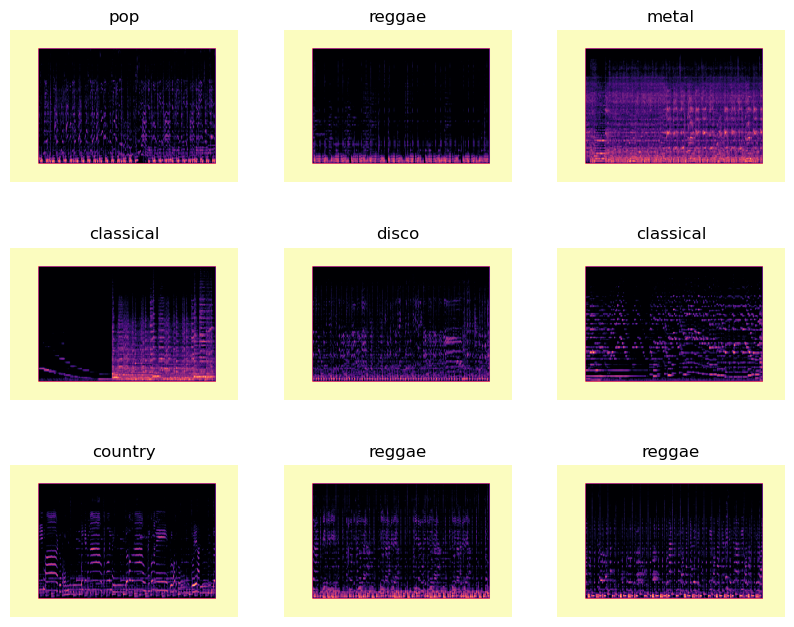

In [2]:
# Define a transform to convert the images to tensors and normalize them
transform = transforms.ToTensor()

# ATTENZIONE: # Queste vanno ricalcolate per un dataset di soli spettrogrammi
# This transform also normalizes
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.466],            
                         std=[0.459])
])


# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'
img_dir = 'Data\\images_original'

# Create the dataset
gtzan_dataset = GTZANDataset(features_file=features_file, img_dir=img_dir, transform=transform_norm)



# Testing the dataset
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(gtzan_dataset), size=(1,)).item()      # This line generates a random tensor with 1 element and the converts it to scalar
    # sample_idx = i
    img, feature, label = gtzan_dataset[sample_idx]                                # 'training_data[sample_idx]' returns a tuple!

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    
    # The image is a [1, 288, 432] tensor, the first dimension is the batch size
    plt.imshow(img[0], cmap="magma")

plt.show()

## Testing the Dataloader

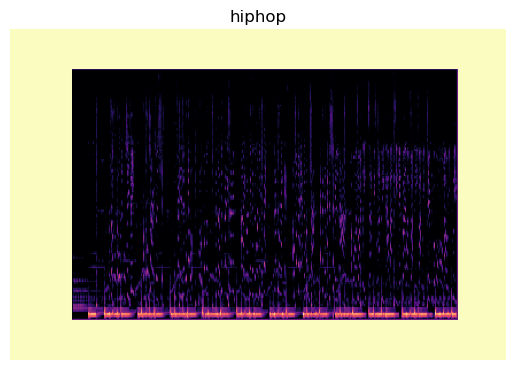

In [3]:
# Create a DataLoader
batch_size = 4
shuffle = True
num_workers = 0           # values over 0 means that it uses more cores to load the data

dataloader = DataLoader(gtzan_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Example of using the dataloader in a training loop
for i, data in enumerate(dataloader):
    images, features, labels = data
    img = images[0]
    plt.imshow(img[0], cmap="magma")
    plt.title(labels[0])
    plt.axis("off")
    break

# Computing the mean and std of spectogram data

This step is important because spectogram have a different distribution then normal images

In [4]:
def compute_mean_std(features_file, img_dir):
    # Basic Transform
    transform = transforms.Compose([transforms.ToTensor()])

    # Create the dataset
    dataset = GTZANDataset(features_file=features_file, img_dir=img_dir, transform=transform)
    
    # Use a Batch size of 1
    dataloader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

    # Initial values
    mean = 0.0
    mean_sq = 0.0
    nb_samples = 0
    
    for i, data in enumerate(dataloader):
        images, features, labels = data
        
        # The image has this shape :(batch_size, RGB_channels, height, width)
        # print(images.shape)
        
        # Here we select the image from the batch
        image = images[0][0]
        # plt.imshow(image, cmap="magma")

        # We sum the mean and std of each channel
        mean += image.mean(dim=(0, 1))
        mean_sq += (image**2).mean(dim=(0, 1))          
        nb_samples += 1

    print(f"Number of samples: {nb_samples}")

    # Computing the mean and the mean of the squares
    mean /= nb_samples
    mean_sq /= nb_samples

    var = mean_sq - mean**2
    std = torch.sqrt(var)
    
    return mean, std


# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'
img_dir = 'Data\\images_original'

# Call this function with the path to your image directory
mean, std = compute_mean_std(features_file, img_dir)

print(f"Mean: {mean}")
print(f"Std: {std}")

Number of samples: 1000
Mean: 0.4665810465812683
Std: 0.4597361981868744
